# DISCO Inverted Pendulum Example

This is a simple example of how to run DISCO on the Pendulum environment of
OpenAI Gym. We'll run 5 different experiments: the vanilla MPPI with access to
the ground truth system parameters; DISCO performing Monte-Carlo sampling on a
prior and later a posterior distribution over some uncertain parameters; and
finally, DISCO using the same prior and posterior distributions as before, but
now computing the Unscented Transform.

We start by importing the required packages.

In [16]:
import math

import matplotlib.pyplot as plt
import torch as th
from torch.distributions.uniform import Uniform

from disco.controllers.amppi import AMPPI
from disco.models.pendulum import PendulumModel
from disco.utils.helper import run_simulation, import_mog, save_progress
from disco.utils.utf import MerweScaledUTF

We also need to specify the cost function we'll use to evaluate performance.
Note that in DISCO the cost function is split in 3 ways, a terminal cost,
an instantaneous *state* cost and an instantaneous *control* cost.

The control cost is inherently computed by the algorithm, however the other two
functions are arguments we must pass to the controller.

In [17]:
def terminal_cost(states):
    weight = th.tensor(0).float()
    costs = th.zeros(states.shape[0])
    return costs.where((states[:, 0] % 2 * PI).abs() < ONE_DEG, weight)

def state_cost(states):
    # Note that theta may range beyond 2*pi
    theta, theta_d = states.chunk(2, dim=1)
    return 50.0 * (theta.cos() - 1) ** 2 + 1.0 * theta_d ** 2

Now let's setup the experiment hyperparameters:

In [18]:
# Constants
PI = math.pi
ONE_DEG = 2 * PI / 360

# Simulation setup
ENV_NAME = "Pendulum-v0"
ITERATIONS = 5
INIT_STATE = th.tensor([math.pi, 0])  # pendulum down position
RENDER = True
SAVE = True

# Parameters distributions, uniform prior and pre-trained MoG posterior
PRIOR = Uniform(low=th.tensor([0.1, 0.1]), high=th.tensor([5.0, 5.0]))
POSTERIOR = import_mog("../data/bayessim/pendulum_mog_L1.0_M1.0.p")

# Model hyperparamaters
model_kwargs = {
    "length": 1.0,  # true parameter
    "mass": 1.0,  # true parameter
}
model = PendulumModel(**model_kwargs)

# Control hyperparameters
controller_kwargs = {
    "observation_space": model.observation_space,
    "action_space": model.action_space,
    "hz_len": 30,  # control horizon
    "n_samples": 500,  # sampled trajectories
    "lambda_": 10.0,  # inverse temperature
    "a_cov": th.eye(1),  # control exploration
    "inst_cost_fn": state_cost,
    "term_cost_fn": terminal_cost,
}

# UT hyperparameters
ut_kwargs = {"n": 2, "alpha": 0.5}  # number of sigma points and scaling
tf = MerweScaledUTF(**ut_kwargs)

Now let's define the test cases we want to cover:

In [19]:
cases = {
    "baseline": {
        "model": {"uncertain_params": None, "params_dist": None},
        "controller": {"params_sampling": "none"},
        "plot_kwargs": {
            "color": "g",
            "label": r"Ground-truth: $\rho$",
        },
    },
#     "mc_prior": {
#         "model": {"uncertain_params": ("length", "mass"), "params_dist": PRIOR},
#         "controller": {"params_sampling": "extended"},
#         "plot_kwargs": {
#             "color": "b",
#             "label": r"MC: $\rho \sim \mathcal{{U}}$"
#         },
#     },
#     "ut_prior": {
#         "model": {"uncertain_params": ("length", "mass"), "params_dist": PRIOR},
#         "controller": {"params_sampling": tf},
#         "plot_kwargs": {
#             "color": "r",
#             "label": r"UT: $\rho \sim \mathcal{{U}}$"
#         },
#     },
#     "mc_posterior": {
#         "model": {
#             "uncertain_params": ("length", "mass"),
#             "params_dist": POSTERIOR,
#         },
#         "controller": {"params_sampling": "extended"},
#         "plot_kwargs": {
#             "color": "k",
#             "label": r"MC: $\rho \sim MoG$"
#         },
#     },
#     "ut_posterior": {
#         "model": {
#             "uncertain_params": ("length", "mass"),
#             "params_dist": POSTERIOR,
#         },
#         "controller": {"params_sampling": tf},
#         "plot_kwargs": {
#             "color": "m",
#             "label": r"UT: $\rho \sim MoG$"
#         },
#     },
}

And we are finally ready to run the simulation loop using the helper function:

Running baseline ...


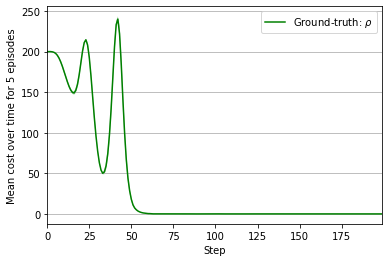

Data saved to: data/local/20200506-132628
Done


/Users/lubaroli/miniconda3/envs/disco/lib/python3.7/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


In [20]:
data_dict = dict()
fig, ax = plt.subplots()
for case in cases.keys():
    print("Running {} ...".format(case))
    model = PendulumModel(**model_kwargs, **cases[case]["model"])
    controller = AMPPI(**controller_kwargs, **cases[case]["controller"])
    if case == list(cases.keys())[-1]:  # last key
        hold = False
    else:
        hold = True
    sim_dict = run_simulation(
        init_state=INIT_STATE,
        episodes=ITERATIONS,
        env_name=ENV_NAME,
        controller=controller,
        model=model,
        verbose=False,
        render=RENDER,
        reuse_ax=ax,
        hold=hold,
        **cases[case]["plot_kwargs"]
    )
    data_dict[case] = sim_dict

    if SAVE:
        folder = save_progress(data=data_dict, fig=fig)
        if folder is not None:
            print("Data saved to: {}".format(folder))
    print("Done")
